In [200]:
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from teaching_tools.widgets import ConfusionMatrixWidget


In [168]:
filepath = r"/users/rsmart/Downloads/iot23_combined.csv"

range_drop = range(26)
def wrangle(filepath):
    df = pd.read_csv(filepath)

    # Dropping leaky columns
    drop_columns = []
    #Binary Encoding of the Target  
    df["Malicious"]= (df["label"]== "Malicious").astype(int)
    #Identifying the Low cardanality features
    for x in range_drop:
        p = df.columns[x]
        if df[p].nunique() == 2 and p != "Malicious":
            drop_columns.append(p)
       
    df.drop(columns=(drop_columns), inplace=True)
    
    return df       

 



In [169]:
df = wrangle(filepath)
#print(df.head())
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246750 entries, 0 to 1246749
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Unnamed: 0     1246750 non-null  int64  
 1   duration       1246750 non-null  float64
 2   orig_bytes     1246750 non-null  int64  
 3   resp_bytes     1246750 non-null  int64  
 4   missed_bytes   1246750 non-null  float64
 5   orig_pkts      1246750 non-null  float64
 6   orig_ip_bytes  1246750 non-null  float64
 7   resp_pkts      1246750 non-null  float64
 8   resp_ip_bytes  1246750 non-null  float64
 9   Malicious      1246750 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 95.1 MB
None
(1246750, 10)


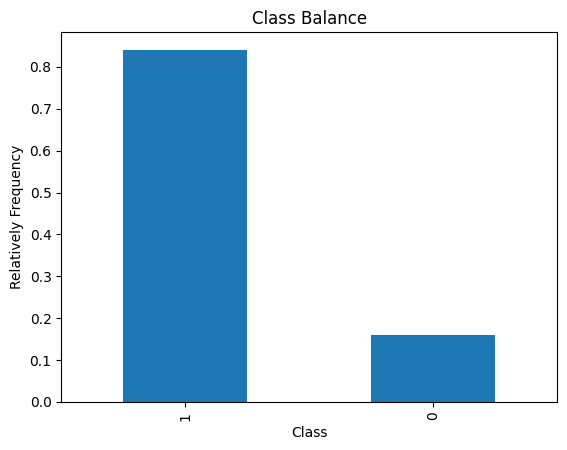

In [170]:
#Comparison of the Malicious and Benign connections

df["Malicious"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="Class",
    ylabel="Relatively Frequency",
    title="Class Balance"
);


In [171]:
#From the Figure above, our dataset is imbalanced so we will need to sample the data

#print(df["Malicious"].value_counts())

#Spliting the clean Data into Target and Feature Vector

target = "Malicious"
X = df.drop(columns=target)
y=df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

#Splitting the clean Data into the Training and Test Sets(Using 20% of our total data as test set)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X shape: (1246750, 9)
y shape: (1246750,)
X_train shape: (997400, 9)
y_train shape: (997400,)
X_test shape: (249350, 9)
y_test shape: (249350,)


In [172]:
#Model baseline accuracy score
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.8407


In [174]:
predictor = RandomForestClassifier()

In [175]:
#Parameter Grid Tunning

params = {
    "max_depth": range(18,21,1),
    "n_estimators": range(79,81,1)
}

params

{'max_depth': range(18, 21), 'n_estimators': range(79, 81)}

In [176]:
#Creating the Model Using GridSearchCV

model = GridSearchCV(
    predictor,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1 
)

model

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(18, 21),
                         'n_estimators': range(79, 81)},
             verbose=1)

In [179]:
# Fitting the Model with the Over_Sampled Training Data Set

model.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(18, 21),
                         'n_estimators': range(79, 81)},
             verbose=1)

In [180]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,424.272573,7.380152,4.340239,0.907204,18,79,"{'max_depth': 18, 'n_estimators': 79}",0.898085,0.897920,0.898501,0.897839,0.897864,0.898042,0.000245,2
1,438.983168,5.907141,3.873370,0.517895,18,80,"{'max_depth': 18, 'n_estimators': 80}",0.898140,0.897990,0.898436,0.897920,0.897960,0.898089,0.000189,1
2,442.685777,4.437210,4.736233,0.944369,19,79,"{'max_depth': 19, 'n_estimators': 79}",0.897930,0.897905,0.898361,0.897689,0.898110,0.897999,0.000225,4
3,461.834002,8.045891,5.188608,1.163245,19,80,"{'max_depth': 19, 'n_estimators': 80}",0.898110,0.897754,0.898461,0.897839,0.897844,0.898002,0.000259,3
4,485.928162,53.796046,5.614854,1.418159,20,79,"{'max_depth': 20, 'n_estimators': 79}",0.898110,0.897739,0.898110,0.897649,0.897719,0.897865,0.000202,6
5,475.908795,130.507445,3.313243,0.822666,20,80,"{'max_depth': 20, 'n_estimators': 80}",0.897935,0.897829,0.898351,0.897819,0.897739,0.897935,0.000217,5


In [188]:
model.best_params_

{'max_depth': 18, 'n_estimators': 80}

In [182]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
print(acc_train)
print(acc_test)

0.8997704030479245
0.8983998395829156


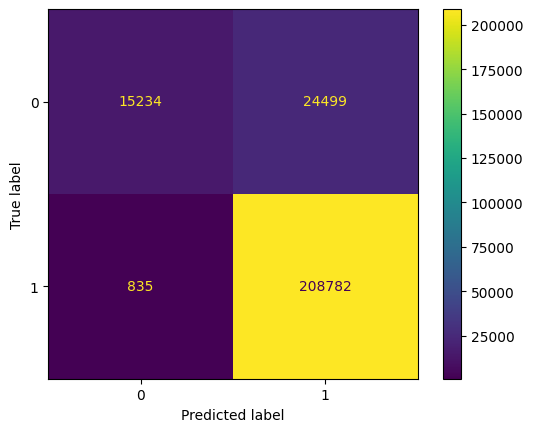

In [183]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

In [184]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.38      0.55     39733
           1       0.89      1.00      0.94    209617

    accuracy                           0.90    249350
   macro avg       0.92      0.69      0.74    249350
weighted avg       0.90      0.90      0.88    249350



In [186]:
c = ConfusionMatrixWidget(model, X_test, y_test)
c.show()

FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=1.0)

In [187]:
c.show_eu()

FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=1.0)

In [194]:
#Communicating Model results

#Get feature names from training data
features = X_train.columns

#Extract Feature Importances from model
importances = model.best_estimator_.feature_importances_

#Create a Series with feature name and importances
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp

missed_bytes     0.000039
resp_pkts        0.036946
resp_ip_bytes    0.040123
orig_pkts        0.065555
orig_bytes       0.076884
Unnamed: 0       0.081308
resp_bytes       0.098822
orig_ip_bytes    0.212450
duration         0.387874
dtype: float64

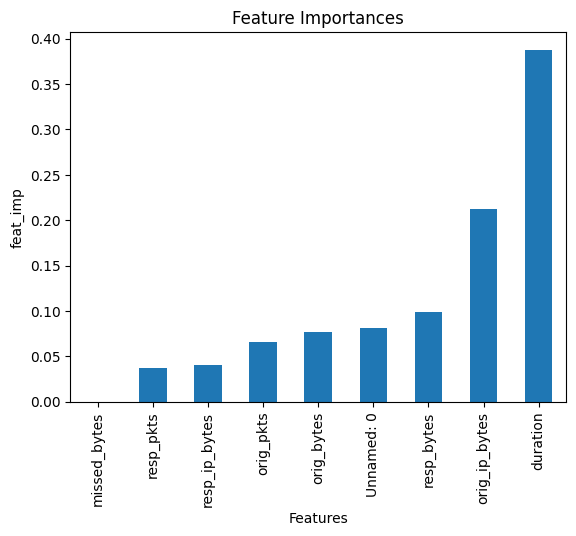

In [197]:
#Plotting the Important Features
feat_imp.plot(kind="bar")
plt.xlabel("Features")
plt.ylabel("feat_imp")
plt.title("Feature Importances");

In [199]:
# Save Model
with open("IOTMaliciousDect.pkl", "wb") as f:
    pickle.dump(model, f)
